In [2]:
import os
import datetime
import keyring
import time
import shutil
from difflib import SequenceMatcher
import difflib
import pandas as pd
pd.set_option("display.max_columns", None) # To display all the columns in the output
pd.set_option("display.max_rows", None) # To display all the rows in the output
import numpy as np
pd.set_option('mode.chained_assignment', None)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from openpyxl import load_workbook


import pyhdb # python hana db connection
from hdbcli import dbapi # SAP HANA database API

# check versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Seaborn version: {sns.__version__}')

SyntaxError: invalid syntax (<ipython-input-2-909a97c26a65>, line 6)

In [7]:
# Date of last run
print(datetime.datetime.now().ctime())

Mon Aug 30 14:29:14 2021


In [8]:
# Set Parameters
country = "Mali" # set country name for the filter
country_code = 'ML'
project_name = 'Liste beneficiare Juin 2021'
country_dir = "../../COs/{}/{}/".format(country, project_name)
template_file = "../../Templates/Importation Template.xlsx"
parquet_dir = "../../COs/{}/parquets/".format(country)
data_dir = country_dir + "data/" #set output directory to place parquet
output = country_dir + "output/"
correct_length_of_CNI = 13

In [9]:
# Check if your directories exists
if os.path.isdir(country_dir):
    print('Your directory {} exists'.format(country_dir))
    
if os.path.isdir(data_dir):
    print('The data directory {} exists'.format(data_dir))

if os.path.isdir(output):
    print('The output directory {} exists'.format(output))
    
shutil.copyfile(template_file, output+'Importation Template.xlsx')

Your directory ../../COs/Mali/Liste beneficiare Juin 2021/ exists
The data directory ../../COs/Mali/Liste beneficiare Juin 2021/data/ exists
The output directory ../../COs/Mali/Liste beneficiare Juin 2021/output/ exists


'../../COs/Mali/Liste beneficiare Juin 2021/output/Importation Template.xlsx'

In [89]:
#Helpers function
def first_letters(s, num_letter=2):
    return s.str[:num_letter].str.upper()

def plotDataFrame_Bar(d,type , title):
    fig, ax = plt.subplots(figsize =(16, 9))
    ax.barh(d[type], d['Counts'])
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
        
    x = d[type]
    y = d['Counts']
    # Set the x ticks
    ax.set_yticks(d[type])
    # Remove x, y Ticks
    
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # add labels to the bar
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 10)
    ax.yaxis.set_tick_params(pad = 1)
    
    # Add x, y gridlines
    ax.grid(b= True, color ='blue', linestyle ='-.', linewidth =1, alpha = 0.2)
    
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
                 str(round((i.get_width()), 2)),
                 fontsize = 10, fontweight ='bold',
                 color ='grey')
    
    ax.set_title(title, loc='center',)
    
    plt.show()
    
def createDFforLengthDist(df, column, type):
    d = (pd.value_counts(df[column].values, sort=True)).to_frame()
    d.reset_index(inplace = True)
    d = d.rename(columns={0:'Counts', 'index':type})
    d = d.sort_values(by=type)
    return d

def removeUnnamedColumn(df):
    for c in df.columns:
        if c.__contains__('Unnamed'):
            df.drop(c, inplace=True, axis=1)
            
def percentNullValues(df, column):
    percent = round(df[column].isna().sum()/len(df) * 100, 2)
    print(f'for the columns {column}, you have {percent} % null values')
    
def save_to_excel(df, filename):
    df.to_excel(output + filename + '.xlsx')
    
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def wuzzyfuzzy(df1, df2):
    myList = []
    total = len(df1)
    possibilities = list(df2.FDP.sort_values())

    s = SequenceMatcher(isjunk=None, autojunk=False)

    for idx1, df1_str in enumerate(df1.Location.str.capitalize()):
        # get 1 best match that has a ratio of at least 0.7
        best_match = difflib.get_close_matches(df1_str, possibilities, 1, 0.7)
        s.set_seqs(df1_str, best_match)
        myList.append(best_match)

    return myList

def createDFforLengthDist(df, column, type):
    d = (pd.value_counts(df[column].values, sort=True)).to_frame()
    d.reset_index(inplace = True)
    d = d.rename(columns={0:'Counts', 'index':type})
    d = d.sort_values(by=type)
    return d

In [11]:
df_template = pd.read_excel(template_file, skiprows=1)
removeUnnamedColumn(df_template)
df_template.head()

,Household Name,Location,Address,Household Size,Document Type,Document Num,Last Name,First Name,Middle Name,Household Role,Recipient,Gender,Marital Status,Date of Birth,Age,Phone Number,Mobile Number,Bank Account Number,Household Vulnerable,Language Code,E Card Status,Physical Disability Status,Mental Disability Status,Orphan,Height,Weight,MUAC,Breastfeeding,Malnourished,Pregnant,Qualified,photo_data


In [40]:
dfi = []
files = os.listdir(data_dir)
for file in files:
    if file.endswith('.xlsx'):
        data = pd.read_excel(data_dir + file, skiprows=1)
        for i in range(2):
            print(f'for the file {os.path.basename(file)} the first column is {data.columns[0]} at skiprows {i}')
            if data.columns[0] == 'Household Name':
                data['Filename'] = os.path.basename(file)
                dfi.append(data)
                break
            else:
                data = pd.read_excel(data_dir + file, skiprows=i)
                continue
#    elif file.endswith('csv'):
        #csv_data = pd.read_csv(data_dir + file, delimiter='\t')
        #csv_data['Filename'] = os.path.basename(file)
        #dfi.append(csv_data)

C:\Program Files\Python39\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


for the file Liste  IDP _ World Vision Juin  2021 -.xlsx the first column is Household Name at skiprows 0
for the file Liste Bankass_Bankass-Segue_YAGTU_Juin 2021.xlsx the first column is Household Name at skiprows 0
for the file Liste Bankass_Diallassagou_YAGTU_Juin 2021.xlsx the first column is Household Name at skiprows 0
for the file Liste Bankass_Kani Bozon YAGTU_Juin 2021.xlsx the first column is Household Name at skiprows 0
for the file Liste Bankass_Koulogon Habe_YAGTU_Juin 2021.xlsx the first column is Household Name at skiprows 0
for the file Liste Bankass_Lessagou Habe_YAGTU_Juin 2021.xlsx the first column is Household Name at skiprows 0
for the file Liste Bankass_Soubala-YAGTU_Juin 2021.xlsx the first column is Household Name at skiprows 0
for the file Liste Bankass_TORI_YAGTU_Juin 2021.xlsx the first column is Household Name at skiprows 0
for the file Liste Benef Juin IDP Douentza_GRADP.xlsx the first column is Household Name at skiprows 0
for the file Liste beneficiaire D

In [41]:
len(dfi)

13

In [42]:
type(csv_data)

pandas.core.frame.DataFrame

In [43]:
for i in dfi:
    print(i.Filename.unique())

['Liste  IDP _ World Vision Juin  2021 -.xlsx']
['Liste Bankass_Bankass-Segue_YAGTU_Juin 2021.xlsx']
['Liste Bankass_Diallassagou_YAGTU_Juin 2021.xlsx']
['Liste Bankass_Kani Bozon YAGTU_Juin 2021.xlsx']
['Liste Bankass_Koulogon Habe_YAGTU_Juin 2021.xlsx']
['Liste Bankass_Lessagou Habe_YAGTU_Juin 2021.xlsx']
['Liste Bankass_Soubala-YAGTU_Juin 2021.xlsx']
['Liste Bankass_TORI_YAGTU_Juin 2021.xlsx']
['Liste Benef Juin IDP Douentza_GRADP.xlsx']
['Liste beneficiaire Doucoumbo-Mopti.xlsx']
['Liste de Niono _IDP_YAGTU_Juin 2021.xlsx']
['Liste des Beneficiaires Bandiagara-Mopti.xlsx']
['Liste Mopti_IDP Socoura_Juin_ 2021_YAGTU.xlsx']


In [44]:
df = pd.concat(dfi)

In [45]:
df.reset_index(drop=True, inplace=True)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Columns: 266 entries, Household Name to Filename
dtypes: float64(252), object(14)
memory usage: 7.9+ MB


In [47]:
#Remove Unnamed Columns
removeUnnamedColumn(df)

In [48]:
df[df.Filename == 'test.csv']

,Household Name,Location,Address,Household Size,Document Type,Document Num,Last Name,First Name,Middle Name,Household Role,Recipient,Gender,Marital Status,Date of Birth,Age,Phone Number,Mobile Number,Bank Account Number,Household Vulnerable,Language Code,E Card Status,Physical Disability Status,Mental Disability Status,Orphan,Height,Weight,MUAC,Breastfeeding,Malnourished,Pregnant,Qualified,photo_data,Filename


In [49]:
df_original = df.copy()

In [50]:
df.shape

(3880, 33)

In [51]:
for c in df.columns:
    print(c)

Household Name
Location
Address
Household Size
Document Type
Document Num
Last Name
First Name
Middle Name
Household Role
Recipient
Gender
Marital Status
Date of Birth
Age
Phone Number
Mobile Number
Bank Account Number
Household Vulnerable
Language Code
E Card Status
Physical Disability Status
Mental Disability Status
Orphan
Height
Weight
MUAC
Breastfeeding
Malnourished
Pregnant
Qualified
photo_data
Filename


In [52]:
cols = ['Household Name', 'Location', 'Address',
       'Household Size', 'Document Type', 'Document Num', 'Last Name', 'First Name',
       'Middle Name', 'Household Role', 'Recipient', 'Gender', 'Marital Status',
       'Date of Birth', 'Age', 'Phone Number', 'Mobile Number', 'Filename']

In [53]:
df = df[cols]

In [54]:
# Create the admins areas dataframe
admin_areas = pd.read_excel('../../Admin_Areas/MALI.xlsx')

# Column Analysis

## Location Name

In [55]:
len(df.Location.unique())

81

In [49]:
df['Location'].value_counts()

Kani bozon            550
Segué                 300
Tori                  281
Diaba Peulh           243
Diallassagou          126
Lessagou Habe         116
GATHI LOUMO           114
Diaratoula            112
Bandiagara commune    108
Djenne                104
Diondiori              94
Finadji                74
Koïna                  74
Bossosso               65
Sagnona                65
Koulogon Habe          65
Kita                   64
Socoura                64
Barbe                  61
Afrar                  55
Teoudi                 55
Nawri                  54
Bamako-Coura           53
Kounaba                53
Doungoura              52
Gagna                  51
Kemoye                 48
Soumatogo              44
Médina Coura           42
Feyadji                42
Douentza               41
Doucoumbo              38
Darnahim               36
Soubala(Soubala)       33
Tombouctou Coura       30
Tahadjarte             30
Komoguel               27
Million Kin            25
Wailirdé    

In [74]:
df['Location'] = df['Location'].str.strip()
df['Location'] = df.Location.str.title()

In [75]:
diaba_peulh = df[df['Location'] == 'Diaba Peulh']
diaba_peulh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 612
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Household Name     243 non-null    object 
 1   Location           243 non-null    object 
 2   Address            243 non-null    object 
 3   Household Size     243 non-null    float64
 4   Document Type      243 non-null    object 
 5   Document Num       243 non-null    object 
 6   Last Name          243 non-null    object 
 7   First Name         243 non-null    object 
 8   Middle Name        7 non-null      object 
 9   Household Role     243 non-null    object 
 10  Recipient          243 non-null    object 
 11  Gender             243 non-null    object 
 12  Marital Status     243 non-null    object 
 13  Date of Birth      0 non-null      float64
 14  Age                243 non-null    float64
 15  Phone Number       0 non-null      object 
 16  Mobile Number      138 non

In [76]:
df['isLocationCorrect'] = df[df['Location'].isin(admin_areas['FDP'])]['Location']

In [77]:
len(df['isLocationCorrect'].unique())

39

In [78]:
len(df['Location'].unique())

74

In [79]:
round(len(df['isLocationCorrect'].unique())/len(df.Location.unique()) * 100 , 2)

52.7

In [80]:
df['isLocationCorrect'].value_counts()

Tori                281
Diaba Peulh         243
Diallassagou        126
Gathi Loumo         114
Diaratoula          112
Djenne              104
Diondiori            94
Finadji              74
Koulogon Habe        65
Bossosso             65
Socoura              64
Barbe                61
Afrar                55
Teoudi               55
Bamako-Coura         53
Doungoura            52
Gagna                51
Soumatogo            44
Feyadji              42
Douentza             41
Darnahim             36
Soubala(Soubala)     33
Sofara(Fakala)       26
Wailirdé             23
Taga                 21
Toulal Sidi          20
Dialangou            17
Diolly               16
Koloye               16
Sirifi Were          15
Sare Mah             14
Ouro Nema            14
Siratinti            13
Takouti(Socoura)      7
Bassabougou           5
Kangourou             4
Pare                  3
Bankass               3
Name: isLocationCorrect, dtype: int64

In [81]:
df['isLocationCorrect'] = df['isLocationCorrect'].str.title()

In [82]:
df.drop(df[df.Location.isna()].index, inplace=True)

In [83]:
df[df.Location.isna()]

,Household Name,Location,Address,Household Size,Document Type,Document Num,Last Name,First Name,Middle Name,Household Role,Recipient,Gender,Marital Status,Date of Birth,Age,Phone Number,Mobile Number,Filename,isLocationCorrect


In [90]:
incorrect_location = df[df['isLocationCorrect'].isna()][['Location', 'Filename']]
incorrect_location = incorrect_location.drop_duplicates()
incorrect_location['Similar'] = wuzzyfuzzy(incorrect_location, admin_areas)
incorrect_location.head(20)

,Location,Filename,Similar
173,Biba,Liste IDP _ World Vision Juin 2021 -.xlsx,[Bilaba]
349,Koïna,Liste IDP _ World Vision Juin 2021 -.xlsx,[Konza]
384,Simabambara,Liste IDP _ World Vision Juin 2021 -.xlsx,[Sina Bambara]
516,Sofara,Liste IDP _ World Vision Juin 2021 -.xlsx,[Selofara]
689,Kemoye,Liste IDP _ World Vision Juin 2021 -.xlsx,[Kermoye]
690,Tahadjarte,Liste IDP _ World Vision Juin 2021 -.xlsx,[Tahidjarte]
701,Kral 2,Liste IDP _ World Vision Juin 2021 -.xlsx,[Karal I]
721,Karal2,Liste IDP _ World Vision Juin 2021 -.xlsx,[Karsala]
755,Kita,Liste IDP _ World Vision Juin 2021 -.xlsx,[Kita I]
856,Toulel Sidi,Liste IDP _ World Vision Juin 2021 -.xlsx,[Toulal Sidi]


In [91]:
save_to_excel(incorrect_location.sort_values(by='Location'), 'Incorrect Location')

In [81]:
admin_areas[admin_areas['FDP'].str.lower() == 'Feyadji'.lower()]

,Unnamed: 0,Region,Cercle,Commune,Village/Quartier,FDP
5826,5092,Mopti,Tenenkou,Kareri,Feyadji,Feyadji


In [92]:
df.isna().sum()

Household Name          0
Location                0
Address                41
Household Size          0
Document Type           0
Document Num            0
Last Name               6
First Name              0
Middle Name          3584
Household Role          0
Recipient               0
Gender                  0
Marital Status       1484
Date of Birth        3878
Age                     2
Phone Number         3584
Mobile Number        3396
Filename                0
isLocationCorrect    1796
dtype: int64

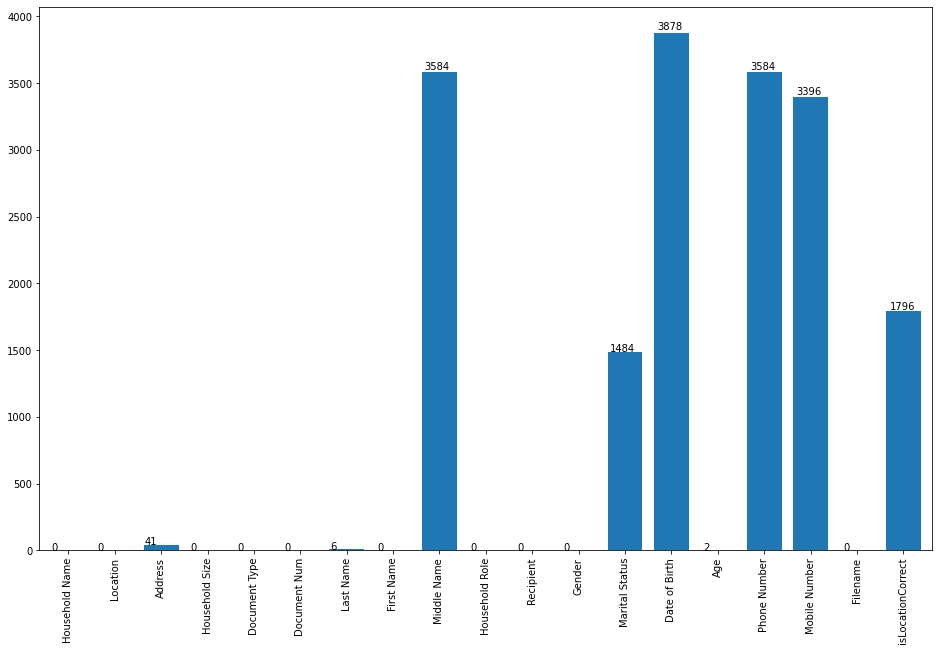

In [95]:
ax = df.isna().sum().plot(kind='bar', figsize=(16, 10), width=0.75, x='HouseholdSize', y='Counts')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [96]:
without_lastname = df[df['Last Name'].isna()]
save_to_excel(without_lastname, 'Without Lastname')
without_lastname

,Household Name,Location,Address,Household Size,Document Type,Document Num,Last Name,First Name,Middle Name,Household Role,Recipient,Gender,Marital Status,Date of Birth,Age,Phone Number,Mobile Number,Filename,isLocationCorrect
889,HH-ML-MOP-0890,Darnahim,Kareri,9.0,WFP ID,ML-MOP-0861,NaN,A,NaN,HD,P,M,MA,NaN,41.0,NaN,NaN,Liste IDP _ World Vision Juin 2021 -.xlsx,Darnahim
987,HH-ML-MOP-0988,Kita,Kareri,2.0,WFP ID,ML-MOP-0959,NaN,Tilel,NaN,HD,P,M,MA,NaN,27.0,NaN,NaN,Liste IDP _ World Vision Juin 2021 -.xlsx,NaN
996,HH-ML-MOP-0997,Kita,Kareri,7.0,WFP ID,ML-MOP-0968,NaN,Imsabdar,NaN,HD,P,M,MA,NaN,40.0,NaN,NaN,Liste IDP _ World Vision Juin 2021 -.xlsx,NaN
1010,HH-ML-MOP-1011,Finadji,Kareri,2.0,WFP ID,ML-MOP-0982,NaN,Soni,NaN,HD,P,M,MA,NaN,20.0,NaN,NaN,Liste IDP _ World Vision Juin 2021 -.xlsx,Finadji
1182,HH-ML-MOP-1183,Afrar,Kareri,6.0,WFP ID,ML-MOP-1154,NaN,Zeinaba,NaN,HD,P,M,MA,NaN,38.0,NaN,NaN,Liste IDP _ World Vision Juin 2021 -.xlsx,Afrar
1287,HH-ML-MOP-1288,Nawri,Kareri,0.0,WFP ID,ML-MOP-1259,NaN,Senou,NaN,HD,P,M,MA,NaN,25.0,NaN,NaN,Liste IDP _ World Vision Juin 2021 -.xlsx,NaN


In [97]:
df['Recipient'].value_counts()

P    3878
Name: Recipient, dtype: int64

In [98]:
df['Gender'].value_counts()

M     2010
F     1866
 M       1
f        1
Name: Gender, dtype: int64

In [99]:
df['Gender'] = df['Gender'].str.strip()
df['Gender'] = df['Gender'].str.capitalize()

In [100]:
df['Gender'].value_counts()

M    2011
F    1867
Name: Gender, dtype: int64

In [101]:
df['Mobile Number'].isna().sum()/ len(df)

0.8757091284167097

In [110]:
df['Age'].dtype

dtype('float64')

In [117]:
df['Mobile Number Length'] = df['Mobile Number'].astype(str).str.len()

In [121]:
df[df['Mobile Number Length'] == 10]

,Household Name,Location,Address,Household Size,Document Type,Document Num,Last Name,First Name,Middle Name,Household Role,Recipient,Gender,Marital Status,Date of Birth,Age,Phone Number,Mobile Number,Filename,isLocationCorrect,Mobile Number Length
3091,HH-MLMOPDOUE0001,Douentza,NaN,6.0,WFP ID,MLMOPDOUE0001,MAMOUDOU,Boura,NaN,HD,P,M,MA,NaN,29.0,NaN,+223759811,Liste Benef Juin IDP Douentza_GRADP.xlsx,Douentza,10
3092,HH-MLMOPDOUE0002,Douentza,NaN,6.0,WFP ID,MLMOPDOUE0002,BARRY,Hamadoun,NaN,HD,P,M,MA,NaN,40.0,NaN,+223771221,Liste Benef Juin IDP Douentza_GRADP.xlsx,Douentza,10
3093,HH-MLMOPDOUE0003,Douentza,NaN,6.0,WFP ID,MLMOPDOUE0003,BARRY,Hamidou,NaN,HD,P,M,MA,NaN,32.0,NaN,+223645641,Liste Benef Juin IDP Douentza_GRADP.xlsx,Douentza,10
3095,HH-MLMOPDOUE0005,Douentza,NaN,6.0,WFP ID,MLMOPDOUE0005,MAMOUDOU,Djibrilou,NaN,HD,P,M,MA,NaN,40.0,NaN,+223715921,Liste Benef Juin IDP Douentza_GRADP.xlsx,Douentza,10
3100,HH-MLMOPDOUE0010,Douentza,NaN,6.0,WFP ID,MLMOPDOUE0010,BARRY,Boucary,NaN,HD,P,M,MA,NaN,32.0,NaN,+223753857,Liste Benef Juin IDP Douentza_GRADP.xlsx,Douentza,10
3101,HH-MLMOPDOUE0011,Douentza,NaN,6.0,WFP ID,MLMOPDOUE0011,KERENA,Oumar,NaN,HD,P,M,MA,NaN,45.0,NaN,+223737593,Liste Benef Juin IDP Douentza_GRADP.xlsx,Douentza,10
3102,HH-MLMOPDOUE0012,Douentza,NaN,6.0,WFP ID,MLMOPDOUE0012,OUMAROU,Aly,NaN,HD,P,M,MA,NaN,23.0,NaN,+223737593,Liste Benef Juin IDP Douentza_GRADP.xlsx,Douentza,10
3103,HH-MLMOPDOUE0013,Douentza,NaN,6.0,WFP ID,MLMOPDOUE0013,BOKA,Amadou,NaN,HD,P,M,MA,NaN,43.0,NaN,+223711283,Liste Benef Juin IDP Douentza_GRADP.xlsx,Douentza,10
3105,HH-MLMOPDOUE0015,Douentza,NaN,6.0,WFP ID,MLMOPDOUE0015,AMADOU,Oumar,NaN,HD,P,M,MA,NaN,29.0,NaN,+223777561,Liste Benef Juin IDP Douentza_GRADP.xlsx,Douentza,10
3108,HH-MLMOPDOUE0018,Douentza,NaN,6.0,WFP ID,MLMOPDOUE0018,ALLAYE,Boura,NaN,HD,P,M,MA,NaN,55.0,NaN,+223626447,Liste Benef Juin IDP Douentza_GRADP.xlsx,Douentza,10


In [120]:
createDFforLengthDist(df, 'Mobile Number Length', 'Length')

,Length,Counts
0,0,3639
6,2,3
3,4,29
2,6,76
1,8,103
7,9,1
5,10,12
8,11,1
4,12,14


In [122]:
df.loc[df['Mobile Number Length'].isin([3]), 'Mobile Number'] = ''
df.loc[df['Mobile Number Length'] < 10, 'Mobile Number'] = ''

In [123]:
df.loc[df['Mobile Number'].astype(str).str.startswith('9999'), 'Mobile Number'] = ''


In [124]:
df[df['Mobile Number'].astype(str).str.startswith('9999')]['Mobile Number']

Series([], Name: Mobile Number, dtype: object)

In [125]:
df.loc[df['Mobile Number'].astype(str).str.startswith('223'), 'Mobile Number'] = '+' + df['Mobile Number'].astype('str')

In [126]:
df['Mobile Number'] = df['Mobile Number'].astype(str).str.replace('.0', '')

<ipython-input-126-f6546ed50fa4>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Mobile Number'] = df['Mobile Number'].astype(str).str.replace('.0', '')


In [127]:
len(df['Household Name'].unique())/len(df)

1.0

# Create the SCOPE Template

In [129]:
df_template['Household Name'] = df['Household Name']
df_template['Location'] = df['Location']
df_template['Address'] = df['Address']
df_template['Household Size'] = df['Household Size']
df_template['Document Type'] = df['Document Type']
df_template['Document Num'] = df['Document Num']
df_template['Last Name'] = df['Last Name']
df_template['First Name'] = df['First Name']
df_template['Middle Name'] = df['Middle Name']
df_template['Household Role'] = df['Household Role']
df_template['Recipient'] = df['Recipient']
df_template['Gender'] = df['Gender']
df_template['Marital Status'] = df['Marital Status']
df_template['Date of Birth'] = df['Date of Birth']
df_template['Age'] = df['Age']
df_template['Mobile Number'] = df['Mobile Number']

In [152]:
df_template.to_excel(output+project_name+'_template.xlsx')

In [130]:
book = load_workbook(output + 'Importation Template.xlsx')
writer = pd.ExcelWriter(output + 'Importation Template.xlsx', engine='openpyxl') 
writer.book = book

writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

df_template.to_excel(writer, index= False, sheet_name= "Data", startrow=2)

writer.save()
writer.close()

C:\Program Files\Python39\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
